<a href="https://colab.research.google.com/github/dtzwang/Personal-Projects/blob/main/bioinformatics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Project based off of Dataprofessor https://github.com/dataprofessor
#install ChEMBL webresource
! pip install chembl_webresource_client

In [2]:
#Import libraries
import pandas as pd
from chembl_webresource_client.new_client import new_client

In [ ]:
#Target search for mycobacterium tuberculosis
target = new_client.target
targetQuery = target.search('mycobacterium tuberculosis')
targets = pd.DataFrame.from_dict(targetQuery)
targets

In [ ]:
#Filter out Phosphotyrosine protein phosphatase
selTarget = targets.target_chembl_id[5]
selTarget

In [ ]:
#Retrieve IC50 level (potency to inhibit certain function)
#standard_value represents concentration needed to inhibit 50% of function - lower is better
activity = new_client.activity
res = activity.filter(target_chembl_id = selTarget).filter(standard_type='IC50')
df = pd.DataFrame.from_dict(res)
df

In [7]:
#write df to csv file
df.to_csv('bioactivity_data.csv', index = False)

In [ ]:
#connect google drive
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

In [9]:
#create google drive folder
! mkdir "/content/gdrive/My Drive/Colab Notebooks/mycoTubData"

In [10]:
! cp bioactivity_data.csv "/content/gdrive/My Drive/Colab Notebooks/mycoTubData"

In [ ]:
! ls "/content/gdrive/My Drive/Colab Notebooks/mycoTubData"

In [ ]:
! head bioactivity_data.csv

In [ ]:
#deal with missing data
df2 = df[df.standard_value.notna()]
df2
#we see there is no missing data in the standard value

In [14]:
#binning compounds into active, intermediate, inactive based on IC50 values per ChEMBL guidelines
bioactivity_class = []
for i in df2.standard_value:
  if float(i) >= 10000:
    bioactivity_class.append("inactive")
  elif float(i) <= 1000:
    bioactivity_class.append("active")
  else:
    bioactivity_class.append("intermediate")

In [23]:
#iterate over molecule ChEMBL id to list
mol_cid = []
for i in df2.molecule_chembl_id:
  mol_cid.append(i)

In [24]:
#iterate over canonical smiles to list
canonical_smiles = []
for i in df2.canonical_smiles:
  canonical_smiles.append(i)

In [25]:
#iterate over molecule ChEMBL id to list
standard_value = []
for i in df2.standard_value:
  standard_value.append(i)

In [ ]:
#combine lists
data_tuples = list(zip(mol_cid, canonical_smiles, bioactivity_class, standard_value))
df3 = pd.DataFrame(data_tuples, columns = ['molecule_chembl_id', 'canonical_smiles', 'bioactivity_class', 'standard_value'])
df3

In [ ]:
pd.concat([df3, pd.Series(bioactivity_class)], axis = 1)

In [29]:
#export preprocessed data
df3.to_csv('bioactivity_preprocessed_data.csv', index = False)

In [ ]:
#export to google drive
! cp bioactivity_preprocessed_data.csv "/content/gdrive/My Drive/Colab Notebooks/mycoTubData"
! ls "/content/gdrive/My Drive/Colab Notebooks/mycoTubData"

In [ ]:
#install conda and rdkit
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [33]:
#calculate Lipinski descriptors - druglikeness of compounds
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [34]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [ ]:
df_lipinski = lipinski(df.canonical_smiles)
df_lipinski

In [ ]:
df3

In [ ]:
#combine dataframes
df_combined = pd.concat([df3, df_lipinski], axis = 1)
df_combined

In [53]:
#convert IC50 to pIC50 to even out distribution
def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = float(i)*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

In [48]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if float(i) > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x

In [ ]:
df_norm = norm_value(df_combined)
df_norm

In [ ]:
#converted table of pIC50 values
df_final = pIC50(df_norm)
df_final

In [102]:
#removal of intermediate bioactivity class
df_2class = df_final[df_final.bioactivity_class != 'intermediate']
df_2class

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL4172469,C[C@H](O)Cc1cc2c(O)c(O)cc(O)c2c(=O)o1,inactive,252.222,0.83310,4.0,6.0,4.684030
1,CHEMBL168,CC1(C)CC[C@]2(C(=O)O)CC[C@]3(C)C(=CC[C@@H]4[C@...,inactive,456.711,7.23360,2.0,2.0,4.655608
2,CHEMBL1765363,Cc1cc(F)ccc1S(=O)(=O)NCCCCCCn1cc(COc2ccc(-c3cc...,active,639.750,6.24442,2.0,9.0,6.823909
3,CHEMBL4213459,O=C(CCCCCCn1cc(COc2ccc(-c3cc(C(=O)O)no3)c(C3CC...,active,671.798,9.15360,2.0,8.0,6.769551
4,CHEMBL4211060,O=C(O)c1noc(-c2ccccc2)c1-c1cccc(-c2ccc(O)c(Cl)...,active,391.810,5.73280,2.0,4.0,6.045757
...,...,...,...,...,...,...,...,...
282,CHEMBL4637373,O=C(O)C(=O)Nc1ccc(C#Cc2ccc(C(F)(F)F)cc2Br)cc1,active,412.161,3.89080,2.0,2.0,6.164944
283,CHEMBL4638011,O=C(O)C(=O)Nc1ccc(C#Cc2ccc(C(F)(F)F)cc2F)cc1,active,351.255,3.26740,2.0,2.0,6.156145
291,CHEMBL4649025,O=C(O)C(=O)Nc1cccc(C#Cc2ccccc2)c1,active,265.268,2.10950,2.0,2.0,6.250264
292,CHEMBL4642395,O=C(O)C(=O)Nc1ccc(-c2ccccc2)cc1,active,241.246,2.37670,2.0,2.0,6.176526


In [56]:
#exploratory data analysis (chemical space analysis) via Lipinski descriptors
import seaborn as sns
sns.set(style = 'ticks')
import matplotlib.pyplot as plt

In [ ]:
#plot frequency
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='bioactivity_class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

In [ ]:
#plot molecular weight vs logP
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

In [ ]:
#pIC50 box plot
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'pIC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

In [60]:
#statistical analysis using Mann-Whitney U Test
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  active = df[df.bioactivity_class == 'active']
  active = active[descriptor]

  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  inactive = df[df.bioactivity_class == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [ ]:
mannwhitney('pIC50')

In [ ]:
#molecular weight boxplot
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [ ]:
mannwhitney('MW')

In [ ]:
#LogP boxplot
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

In [ ]:
mannwhitney('LogP')

In [ ]:
#Number of hydrogen donors boxplot
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

In [ ]:
mannwhitney('NumHDonors')

All of our Lipinski descriptors displayed statistically significant differences between active and inactive values.

In [ ]:
#zip files
!zip -r results.zip . -i *.csv *.pdf

In [ ]:
#downloading PaDEL-Descriptor
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

In [ ]:
! unzip padel.zip

In [ ]:
selection = ['canonical_smiles', 'molecule_chembl_id']
df4 = df_2class[selection]
df4.to_csv('molecule.smi', sep ='\t', index = False, header = False)
df4

In [ ]:
! cat molecule.smi | head -5

In [ ]:
! cat molecule.smi | wc -l

In [ ]:
! cat padel.sh

In [ ]:
#generate csv of molecular descriptors
! bash padel.sh

In [ ]:
#x-variable
df3_X = pd.read_csv('descriptors_output.csv')
df3_X = df3_X.drop(columns = ['Name'])
df3_X

In [ ]:
df_2class.reset_index(drop=True, inplace=True)
df_2class

In [ ]:
#y-variable
df3_Y = df_2class['pIC50']
df3_Y

In [ ]:
#combining X and Y variables
dataset3 = pd.concat([df3_X, df3_Y], axis = 1)
dataset3

In [114]:
dataset3.to_csv('mycotubPTP_06_bioactivity_data_3class_pIC50_pubchem_fp.csv', index=False)

In [115]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [ ]:
X = dataset3.drop('pIC50', axis = 1)
Y = dataset3.pIC50

In [ ]:
print(X.shape)
print(Y.shape)

In [ ]:
#remove low variance features
from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(threshold=(.8 * (1-.8)))
X = selection.fit_transform(X)
X.shape

In [124]:
#split data in 80/20 parts
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size= 0.2)

In [125]:
X_train.shape, Y_train.shape

((153, 151), (153,))

In [127]:
X_test.shape, Y_test.shape

((39, 151), (39,))

In [185]:
#build Random Forest Regression Model
seed = np.random.seed(100)
model = RandomForestRegressor(n_estimators = 100)
model.fit(X_train, Y_train)
r2 = model.score(X_test, Y_test)
r2

0.8224231575320258

In [136]:
Y_pred = model.predict(X_test)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<function matplotlib.pyplot.show>

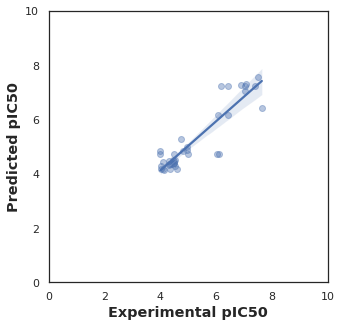

In [138]:
#scatter plot of experimental vs predicted pIC50 values
sns.set(color_codes = True)
sns.set_style("white")
ax = sns.regplot(Y_test, Y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize = 'large', fontweight = 'bold')
ax.set_ylabel('Predicted pIC50', fontsize = 'large', fontweight = 'bold')
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.figure.set_size_inches(5,5)
plt.show